<a href="https://colab.research.google.com/github/yasstake/dl_experiment/blob/main/notebooks/PoseDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMPoseによるポーズ推定サンプル

MMPose をつかって、立っているか、寝ているかの判定を行うサンプルプログラムのQuickHack。精度よりもシンプルに全体の流れをわかりやすく説明したもの。

処理の内容

1. MMPoseのインストール
2. MMPoseによるUSBカメラからのPose取得（17個の点で取得できることを確認する）
3. 学習データの作成
 * 起きているときのデータキャプチャー（１０個分）
 * 寝ているときのデータキャプチャー（１０個分）
 * 学習用データセットの作成（教師データ(y)を追加し、起きているときと寝ている時のデータを１つにまとめる）
4. 特徴量エンジニアリング：（今回はデータの中身をみるだけのつもりが少し追加してみました）
5. LightGBMによる機械学習
6. 学習させたモデルによる予測


予めネタバレしておくと、今回のやり方では頭の位置の情報の影響がとても大きく、画面の中で頭がどこにあるかで起きているか、寝ているか判定してしまっている。今回サボった、３の学習データの作成でのデータ量の追加、４の特徴量エンジニアリングで、場所情報から傾きや、関節ごとの相対位置などに変換して学習・予測させる必要がありそう。

今回の目的の「大きな流れ」を説明するということにおいては関係ないが、うまくできていない点がちょっと悔しい。

# 1. MMPoseのインストール


Install on Google Clab https://mmpose.readthedocs.io/en/latest/installation.html#install-on-google-colab を参考にインストールする。

In [ ]:
# 必要ライブラリのインストール（わりと時間かかります。かつインストール後ランタイムを再起動する必要があります。）
!pip3 install appdirs
!pip3 install openmim
!mim install mmengine
!mim install mmdet
!mim install "mmcv>=2.0.1"

# ここまで実行できたら、ライブラリを有効にするためにランタイムを再起動（セッションのリスタート）してください。

In [ ]:
# MMPoseのGitをクローン（設定ファイルなどを利用するため）
!git clone https://github.com/open-mmlab/mmpose.git
%cd mmpose
!pip install -e .


In [1]:
# インストールされたmmposeのバージョンの確認
import mmpose
print(mmpose.__version__)

1.3.1


# 2. MMPoseによるUSBカメラからのPose取得

In [2]:
# 必要ライブラリのインポート
import logging

from mmcv.image import imread
from mmengine.logging import print_log

from mmpose.apis import inference_topdown
from mmpose.apis import init_model
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples
from mmpose.apis import MMPoseInferencer

In [3]:
# Pose(COCO)検出モデルの設定
# COCOモデルは、https://mmpose.readthedocs.io/en/latest/dataset_zoo/2d_body_keypoint.html　を参照。
model = init_model("/content/mmpose/configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w48_8xb32-210e_coco-256x192.py",
                   'https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_256x192-b9e0b3ab_20200708.pth',
                   device='cpu')


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_256x192-b9e0b3ab_20200708.pth


Downloading: "https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_256x192-b9e0b3ab_20200708.pth" to /root/.cache/torch/hub/checkpoints/hrnet_w48_coco_256x192-b9e0b3ab_20200708.pth
/content/mmpose/mmpose/datasets/datasets/utils.py:102: UserWarning: The metainfo config file "configs/_base_/datasets/coco.py" does not exist. A matched config file "/content/mmpose/mmpose/.mim/configs/_base_/datasets/coco.py" will be used instead.
  warnings.warn(


In [4]:
# USBカメラの画面キャプチャプログラム(photo.jpgへ保存する)
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [5]:
# 画面キャプチャ＆mmposeでの解析

def capture_pose():
  try:
    filename = take_photo()
    #print('Saved to {}'.format(filename))

    # Show the image which was just taken.
    # display(Image(filename))
    batch_result = inference_topdown(model, filename) #ここでMMPOSEが呼ばれる

    return batch_result, filename
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

## 2.1 試しにUSBカメラで画像をキャプチャーしどのような出力になるか確認する。

先にPoseを推定してKeypointを探し出すトップダウンとKeypointになりそうな点を探してPoseを構築するBottomUpの関数２つがあるらしいが、サンプルでつかわれていた`inference_topdown`を使ってPoseを検出する。

```
batch_result = inference_topdown(model, filename) #ここでMMPOSEが呼ばれる
```
で得られたbatch_resultの中の`keypoints`の配列が、各関節のポイント。https://mmpose.readthedocs.io/en/latest/dataset_zoo/2d_body_keypoint.html
ここにCOCOモデルの１７ポイントの説明が書いてある。

例：
* keypoints[0] 喉仏のあたり
* keypoints[16] 右足
* keypoints[17] 左足

scoreはその点の信頼度、visibleは画面上にある確率の推定値。




In [10]:
# レッツトライ（「capture」ボタンを押す）
batch_result, filename = capture_pose()

print(batch_result)

<IPython.core.display.Javascript object>

[<PoseDataSample(

    META INFORMATION
    pad_shape: (256, 192)
    input_center: array([320., 240.], dtype=float32)
    ori_shape: (480, 640)
    input_size: (192, 256)
    batch_input_shape: (256, 192)
    dataset_name: 'coco'
    input_scale: array([ 800.    , 1066.6666], dtype=float32)
    img_path: 'photo.jpg'
    flip_indices: [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15]
    img_shape: (480, 640)

    DATA FIELDS
    gt_instance_labels: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
        ) at 0x7f5274d09f90>
    pred_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            keypoints: array([[[274.16666 ,  77.50001 ],
                        [265.83334 ,  69.16667 ],
                        [290.83334 ,  69.16667 ],
                        [265.83334 ,  85.833336],
                        [307.5     ,  69.16667 ],
                        [274.16666 , 144.16667 ],
         

/usr/local/lib/python3.10/dist-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmpose.visualization.local_visualizer.PoseLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


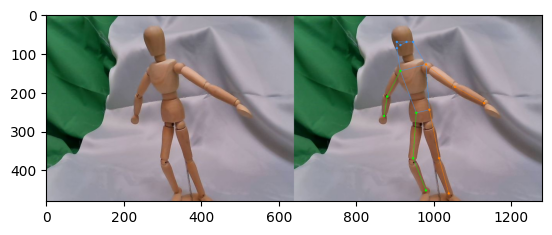

In [11]:
# 画像で確認。左に元画像。右にkeypointのオーバーレイ。visibleの値が低いポイントは表示されない。

from mmpose.structures import merge_data_samples
import matplotlib.pyplot as plt

def print_result(batch_result, title=None):
  # merge results as a single data sample
  results = merge_data_samples(batch_result)

  # build the visualizer
  visualizer = VISUALIZERS.build(model.cfg.visualizer)

  # set skeleton, colormap and joint connection rule
  visualizer.set_dataset_meta(model.dataset_meta)

  img_path=filename

  img = imread(img_path, channel_order='rgb')

  # visualize the results
  img = visualizer.add_datasample(
      'result',
      img,
      data_sample=results,
      show=False)

  if title:
    plt.title(title)

  plt.imshow(img)
  plt.show()


print_result(batch_result)

# 3. 学習用データの作成。

一枚の画像のデータからPoseを示す配列データを取得することができた。そこで、単純のため寝ているデータと起きているデータの２つをつくって学習することにする。

今回は、MMPoseで得られるkeypointのデータだけをつかって学習用データを作成する。（本来はVisibleの値が低い場合は点がないのだから学習データにいれないなどの工夫が必要なはず）

一回キャプチャして分析するとkeypoints[0]-keypoint[16]の１７のKeypointが得られる（データ数としては３４個）



In [12]:
# Keypointデータの確認（前回キャプチャしたデータ）
keypoints = batch_result[0].pred_instances.keypoints[0]
keypoints

array([[274.16666 ,  77.50001 ],
       [265.83334 ,  69.16667 ],
       [290.83334 ,  69.16667 ],
       [265.83334 ,  85.833336],
       [307.5     ,  69.16667 ],
       [274.16666 , 144.16667 ],
       [340.83334 , 127.50001 ],
       [240.83333 , 210.83333 ],
       [415.83334 , 185.83333 ],
       [232.5     , 260.83334 ],
       [490.83334 , 227.5     ],
       [315.83334 , 252.5     ],
       [349.16666 , 244.16667 ],
       [307.5     , 369.16666 ],
       [374.16666 , 369.16666 ],
       [340.83334 , 452.5     ],
       [399.16666 , 460.8333  ]], dtype=float32)

# 3.1 起きているデータの作成

起きている状態の写真を、とりあえず１０個キャプチャーして結果を`standing_data`にいれてみよう。

<IPython.core.display.Javascript object>

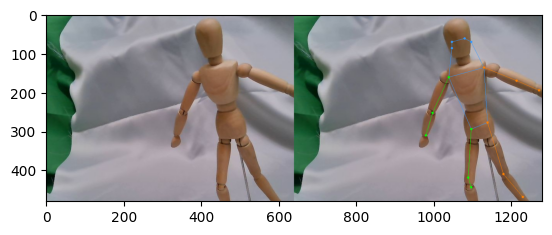

<IPython.core.display.Javascript object>

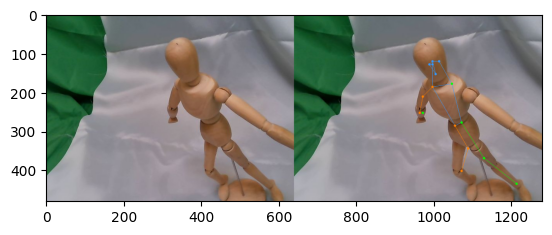

<IPython.core.display.Javascript object>

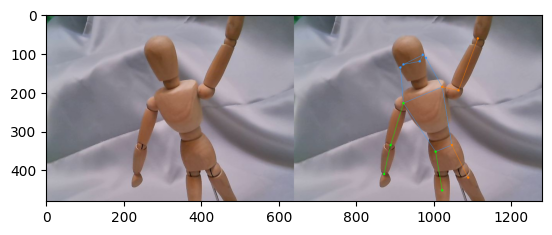

<IPython.core.display.Javascript object>

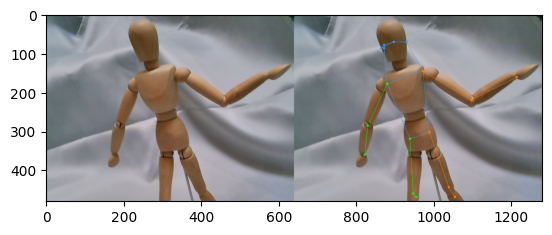

<IPython.core.display.Javascript object>

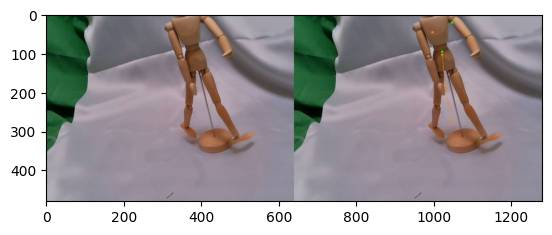

<IPython.core.display.Javascript object>

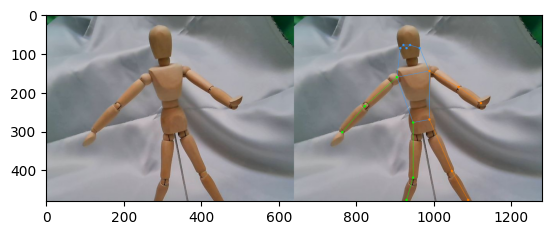

<IPython.core.display.Javascript object>

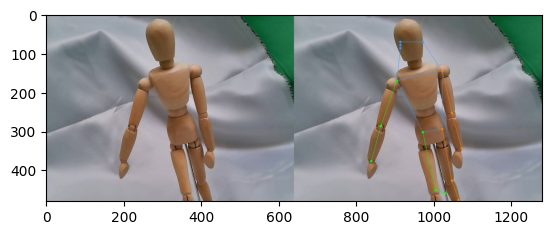

<IPython.core.display.Javascript object>

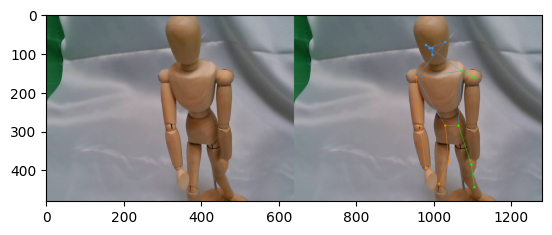

<IPython.core.display.Javascript object>

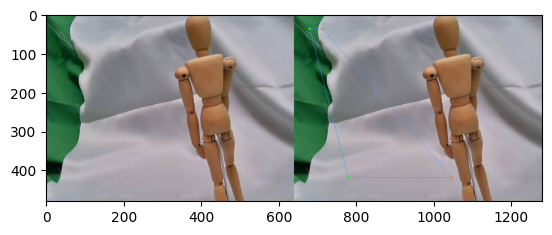

<IPython.core.display.Javascript object>

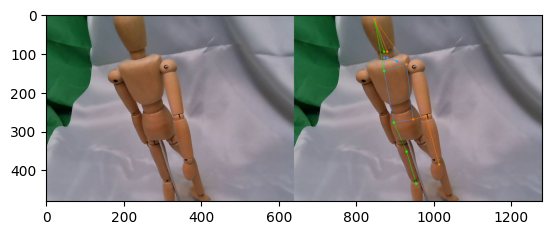

In [13]:
import numpy as np

# USBカメラでキャプチャし、データをtrain_dataに追加する。
def capture(standing, train_data):
  batch_result, filename = capture_pose()
  keypoints = batch_result[0].pred_instances.keypoints[0]   # 17個の座標が得られる。
  row = keypoints.flatten() #　34個のデータへ展開。
  train_data = np.insert(train_data, 0, row, axis=0) #データを追加
  print_result(batch_result) #結果を表示

  return train_data


standing_data = np.empty((0, 34))


# 10回キャプチャする。
for i in range(10):
  standing_data = capture(0, standing_data)


In [14]:
# キャプチャーできたPoseデータ１０個の内容を確認する。
print(standing_data.shape)
print(standing_data)

(10, 34)
[[282.5        127.50000763 282.5        119.16667175 265.83334351
  119.16667175 232.5        110.83333588 240.83332825 110.83333588
  232.5        144.16667175 290.83334351 127.50000763 207.5
   10.8333416  207.5         10.8333416  232.5         94.16667175
  240.83332825  94.16667175 257.5        277.5        307.5
  269.16665649 290.83334351 352.5        340.83334351 260.83334351
  315.83334351 435.83331299 374.16665649 385.83331299]
 [ 90.83333588 244.16667175  74.16666412 177.5         74.16666412
  144.16667175 115.83333588 427.5        449.16665649 435.83331299
   40.83333206  35.83333969  74.16666412  35.83333969  32.5
  210.83332825  40.83333206 135.83334351 274.16665649 419.16665649
  274.16665649 419.16665649 140.83332825 419.16665649 407.5
  419.16665649  32.5         60.83333969 207.5         77.50000763
  407.5         85.83333588  74.16666412  44.16667557]
 [357.5        102.50000763 357.5         85.83333588 349.16665649
   85.83333588 340.83334351  77.500007

# 3.2 寝ているときのデータ作成

今度は`sleeping_data`を作成する。

<IPython.core.display.Javascript object>

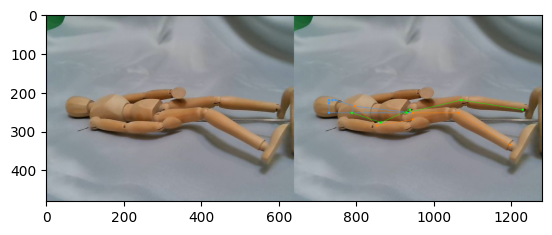

<IPython.core.display.Javascript object>

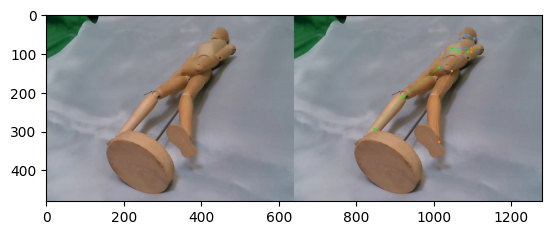

<IPython.core.display.Javascript object>

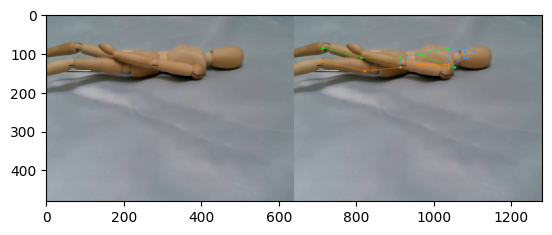

<IPython.core.display.Javascript object>

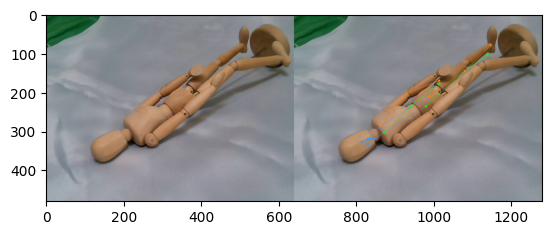

<IPython.core.display.Javascript object>

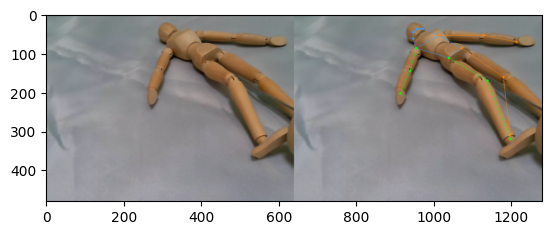

<IPython.core.display.Javascript object>

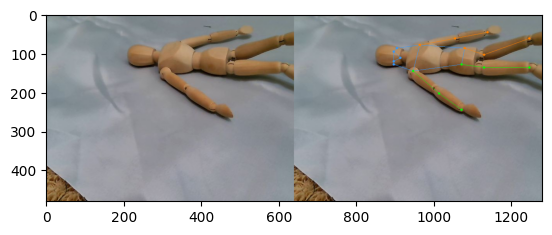

<IPython.core.display.Javascript object>

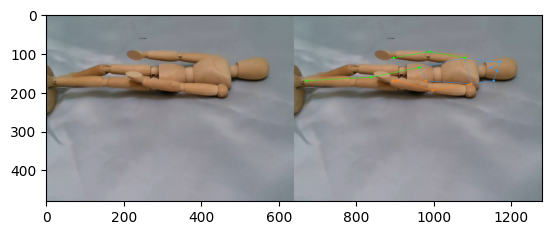

<IPython.core.display.Javascript object>

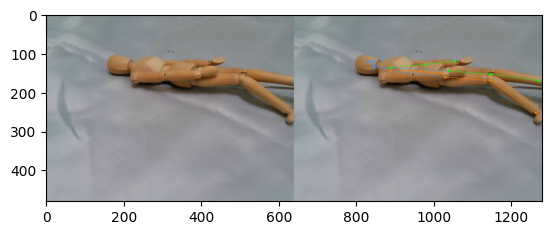

<IPython.core.display.Javascript object>

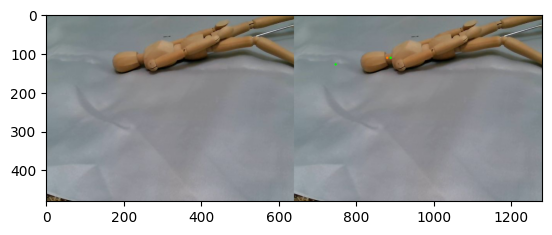

<IPython.core.display.Javascript object>

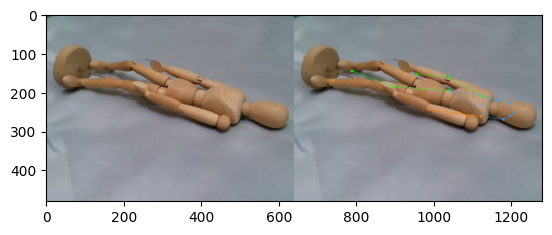

In [15]:
sleeping_data = np.empty((0, 34))


# 10回キャプチャする。
for i in range(10):
  sleeping_data = capture(0, sleeping_data)

In [16]:
# キャプチャーできたPoseデータ１０個の内容を確認する。
print(sleeping_data.shape)
print(sleeping_data)

(10, 34)
[[565.83331299 260.83334351 565.83331299 252.5        557.5
  260.83334351 557.5        227.5        540.83331299 269.16665649
  490.83334351 210.83332825 482.5        260.83334351 399.16665649
  160.83334351 349.16665649 244.16667175 315.83334351 152.5
  449.16665649 260.83334351 399.16665649 194.16667175 482.5
  244.16667175 257.5        185.83332825 324.16665649 235.83332825
  149.16667175 144.16667175  99.16666412 169.16667175]
 [249.16667175  77.50000763 257.5         94.16667175 249.16667175
   85.83333588 224.16667175  85.83333588 224.16667175  85.83333588
   49.16666794 135.83334351 290.83334351  85.83333588 107.5
  127.50000763 115.83333588 127.50000763 240.83332825 110.83333588
   82.5        210.83332825  40.83333206 410.83331299 290.83334351
   85.83333588 265.83334351 110.83333588 340.83334351  94.16667175
  249.16667175 110.83333588 240.83332825 110.83333588]
 [207.5        119.16667175 190.83332825 119.16667175 199.16667175
  119.16667175 207.5        135.833343

## 3.3 学習用データセットの作成（教師データ(y)を追加し、起きているときと寝ている時のデータを１つにまとめる）

In [17]:
# standingデータの最後に０（＝立っている）を追加する
data_num = standing_data.shape[0]

# 起きているときの値は０とする。
y = np.zeros((data_num, 1))

standing_data_with_y = np.append(standing_data, y, axis=1)

standing_data_with_y

array([[282.5       , 127.50000763, 282.5       , 119.16667175,
        265.83334351, 119.16667175, 232.5       , 110.83333588,
        240.83332825, 110.83333588, 232.5       , 144.16667175,
        290.83334351, 127.50000763, 207.5       ,  10.8333416 ,
        207.5       ,  10.8333416 , 232.5       ,  94.16667175,
        240.83332825,  94.16667175, 257.5       , 277.5       ,
        307.5       , 269.16665649, 290.83334351, 352.5       ,
        340.83334351, 260.83334351, 315.83334351, 435.83331299,
        374.16665649, 385.83331299,   0.        ],
       [ 90.83333588, 244.16667175,  74.16666412, 177.5       ,
         74.16666412, 144.16667175, 115.83333588, 427.5       ,
        449.16665649, 435.83331299,  40.83333206,  35.83333969,
         74.16666412,  35.83333969,  32.5       , 210.83332825,
         40.83333206, 135.83334351, 274.16665649, 419.16665649,
        274.16665649, 419.16665649, 140.83332825, 419.16665649,
        407.5       , 419.16665649,  32.5       ,  60

In [18]:
# sleepingデータの最後に１（＝寝ている）を追加する
data_num = sleeping_data.shape[0]

# 寝ているときの値は１とする。
y = np.ones((data_num, 1))

sleeping_data_with_y = np.append(sleeping_data, y, axis=1)

sleeping_data_with_y

array([[565.83331299, 260.83334351, 565.83331299, 252.5       ,
        557.5       , 260.83334351, 557.5       , 227.5       ,
        540.83331299, 269.16665649, 490.83334351, 210.83332825,
        482.5       , 260.83334351, 399.16665649, 160.83334351,
        349.16665649, 244.16667175, 315.83334351, 152.5       ,
        449.16665649, 260.83334351, 399.16665649, 194.16667175,
        482.5       , 244.16667175, 257.5       , 185.83332825,
        324.16665649, 235.83332825, 149.16667175, 144.16667175,
         99.16666412, 169.16667175,   1.        ],
       [249.16667175,  77.50000763, 257.5       ,  94.16667175,
        249.16667175,  85.83333588, 224.16667175,  85.83333588,
        224.16667175,  85.83333588,  49.16666794, 135.83334351,
        290.83334351,  85.83333588, 107.5       , 127.50000763,
        115.83333588, 127.50000763, 240.83332825, 110.83333588,
         82.5       , 210.83332825,  40.83333206, 410.83331299,
        290.83334351,  85.83333588, 265.83334351, 110

In [19]:
# ひとつにデータをまとめる

data_set = np.append(standing_data_with_y, sleeping_data_with_y, axis=0)
print(data_set.shape)
print(data_set)

(20, 35)
[[282.5        127.50000763 282.5        119.16667175 265.83334351
  119.16667175 232.5        110.83333588 240.83332825 110.83333588
  232.5        144.16667175 290.83334351 127.50000763 207.5
   10.8333416  207.5         10.8333416  232.5         94.16667175
  240.83332825  94.16667175 257.5        277.5        307.5
  269.16665649 290.83334351 352.5        340.83334351 260.83334351
  315.83334351 435.83331299 374.16665649 385.83331299   0.        ]
 [ 90.83333588 244.16667175  74.16666412 177.5         74.16666412
  144.16667175 115.83333588 427.5        449.16665649 435.83331299
   40.83333206  35.83333969  74.16666412  35.83333969  32.5
  210.83332825  40.83333206 135.83334351 274.16665649 419.16665649
  274.16665649 419.16665649 140.83332825 419.16665649 407.5
  419.16665649  32.5         60.83333969 207.5         77.50000763
  407.5         85.83333588  74.16666412  44.16667557   0.        ]
 [357.5        102.50000763 357.5         85.83333588 349.16665649
   85.833335

# 4.特徴量エンジニアリング（今回はみるだけ）

データを扱いやすくするためにDataFrameに変換して中身を確認する。

In [20]:
# DataFrameへ変換
import pandas as pd

df = pd.DataFrame(data_set,columns=
                  [
                    "x0", "y0",
                    "x1", "y1",
                    "x2", "y2",
                    "x3", "y3",
                    "x4", "y4",
                    "x5", "y5",
                    "x6", "y6",
                    "x7", "y7",
                    "x8", "y8",
                    "x9", "y9",
                    "x10", "y10",
                    "x11","y11",
                    "x12","y12",
                    "x13","y13",
                    "x14", "y14",
                    "x15", "y15",
                    "x16", "y16",
                    "Y"])


df

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,y12,x13,y13,x14,y14,x15,y15,x16,y16,Y
0,282.500000,127.500008,282.500000,119.166672,265.833344,119.166672,232.500000,110.833336,240.833328,110.833336,...,269.166656,290.833344,352.500000,340.833344,260.833344,315.833344,435.833313,374.166656,385.833313,0.0
1,90.833336,244.166672,74.166664,177.500000,74.166664,144.166672,115.833336,427.500000,449.166656,435.833313,...,419.166656,32.500000,60.833340,207.500000,77.500008,407.500000,85.833336,74.166664,44.166676,0.0
2,357.500000,102.500008,357.500000,85.833336,349.166656,85.833336,340.833344,77.500008,390.833344,69.166672,...,285.833344,457.500000,385.833313,399.166656,377.500000,465.833344,444.166656,374.166656,435.833313,0.0
3,274.166656,85.833336,274.166656,77.500008,274.166656,69.166672,274.166656,85.833336,332.500000,69.166672,...,294.166656,365.833344,452.500000,407.500000,427.500000,390.833344,460.833313,424.166656,477.500000,0.0
4,290.833344,85.833336,282.500000,77.500008,299.166656,77.500008,274.166656,85.833336,324.166656,85.833336,...,269.166656,307.500000,419.166656,407.500000,402.500000,290.833344,477.500000,449.166656,477.500000,0.0
5,382.500000,19.166676,399.166656,85.833336,390.833344,19.166676,399.166656,60.833340,357.500000,60.833340,...,102.500008,424.166656,202.500000,390.833344,185.833328,432.500000,277.500000,407.500000,277.500000,0.0
6,224.166672,85.833336,232.500000,77.500008,257.500000,69.166672,232.500000,85.833336,290.833344,69.166672,...,302.500000,307.500000,460.833313,399.166656,444.166656,315.833344,469.166656,415.833344,469.166656,0.0
7,324.166656,119.166672,282.500000,127.500008,332.500000,102.500008,274.166656,135.833344,340.833344,110.833336,...,335.833344,382.500000,452.500000,449.166656,419.166656,390.833344,485.833313,482.500000,485.833313,0.0
8,365.833344,152.500000,357.500000,119.166672,349.166656,127.500008,374.166656,119.166672,357.500000,127.500008,...,285.833344,490.833344,369.166656,449.166656,344.166656,574.166687,435.833313,432.500000,402.500000,0.0
9,432.500000,69.166672,407.500000,69.166672,440.833344,60.833340,407.500000,85.833336,457.500000,69.166672,...,277.500000,449.166656,419.166656,540.833313,410.833313,457.500000,444.166656,590.833313,469.166656,0.0


# (おまけ）ちょっとだけ特徴量作成もやってみる。

体勢ではなくて、どうしても頭の位置を判定してしまうので、特徴量作成もちょっとやってみる（実はこれでもうまくいかない）。
さらに特徴量つくったり、位置に依存するデータを消したり、元画像のオーグメンテーションをおこなってバリエーション増やしたりなどの作戦が必要。

* 右肩が`(x4, y4)`, 右脚付け根が`(x12, y12)` → 右体側の単位ベクトル =`(x4-x12, y4-y12)/（長さ）`
* 左肩が`(x5, y5), 左脚付け根が`(x11, y11)` →左体側の単位ベクトル = `(x5-x11, y5-y11)/（長さ）`

In [39]:
# a, bのベクトルから単位ベクトルを作る（＆そして見た目の問題で長さを１００倍にしておく）
def calc_vector(a, b):
  a = np.array(a)
  b = np.array(b)
  l = np.linalg.norm(b-a)
  if l:
    z = (b-a) / l * 100   # 単位ベクトルだと最大で１にしかならないので大きくしておく（ほぼ見た目の問題）
  else:
    (b-a)
  return z.T

#　体側の右側と左側のベクトルをDataFrameに追加する。
def add_features(df):
  left = pd.DataFrame(calc_vector((df['x4'], df['y4']), (df['x12'], df['y12'])), columns=['left_x', 'left_y'])
  right = pd.DataFrame(calc_vector((df['x5'], df['y5']), (df['x11'], df['y11'])), columns=['right_x', 'right_y'])

  return pd.concat([df, left, right], axis=1)


In [22]:
# あたらしい特徴量を追加する。パッと見た目、left_y, right_yの大きさだけでも判断できそう。
new_df = add_features(df)
new_df

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,y14,x15,y15,x16,y16,Y,left_x,left_y,right_x,right_y
0,282.500000,127.500008,282.500000,119.166672,265.833344,119.166672,232.500000,110.833336,240.833328,110.833336,...,260.833344,315.833344,435.833313,374.166656,385.833313,0.0,8.691546,20.642420,3.475007,18.533371
1,90.833336,244.166672,74.166664,177.500000,74.166664,144.166672,115.833336,427.500000,449.166656,435.833313,...,77.500008,407.500000,85.833336,74.166664,44.166676,0.0,-5.432215,-2.172885,13.900028,53.283442
2,357.500000,102.500008,357.500000,85.833336,349.166656,85.833336,340.833344,77.500008,390.833344,69.166672,...,377.500000,465.833344,444.166656,374.166656,435.833313,0.0,0.000000,28.247524,-1.158337,19.691708
3,274.166656,85.833336,274.166656,77.500008,274.166656,69.166672,274.166656,85.833336,332.500000,69.166672,...,427.500000,390.833344,460.833313,424.166656,477.500000,0.0,6.518659,29.333965,9.266684,18.533371
4,290.833344,85.833336,282.500000,77.500008,299.166656,77.500008,274.166656,85.833336,324.166656,85.833336,...,402.500000,290.833344,477.500000,449.166656,477.500000,0.0,3.259330,23.901749,5.791677,16.216699
5,382.500000,19.166676,399.166656,85.833336,390.833344,19.166676,399.166656,60.833340,357.500000,60.833340,...,185.833328,432.500000,277.500000,407.500000,277.500000,0.0,3.259330,5.432216,2.316670,10.425021
6,224.166672,85.833336,232.500000,77.500008,257.500000,69.166672,232.500000,85.833336,290.833344,69.166672,...,444.166656,315.833344,469.166656,415.833344,469.166656,0.0,7.605100,30.420410,8.108349,19.691706
7,324.166656,119.166672,282.500000,127.500008,332.500000,102.500008,274.166656,135.833344,340.833344,110.833336,...,419.166656,390.833344,485.833313,482.500000,485.833313,0.0,8.691544,29.333968,11.583359,17.375036
8,365.833344,152.500000,357.500000,119.166672,349.166656,127.500008,374.166656,119.166672,357.500000,127.500008,...,344.166656,574.166687,435.833313,432.500000,402.500000,0.0,7.605104,20.642422,3.475007,13.900029
9,432.500000,69.166672,407.500000,69.166672,440.833344,60.833340,407.500000,85.833336,457.500000,69.166672,...,410.833313,457.500000,444.166656,590.833313,469.166656,0.0,5.432215,27.161080,8.108352,18.533369


In [23]:
# DataFrameつくったときのお作法として内容を確認する。（本当はNULL値の確認、分布の確認、傾向の確認とかいろいろやることあるけどサボって統計値を表示）
new_df.describe()

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,y14,x15,y15,x16,y16,Y,left_x,left_y,right_x,right_y
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,316.666667,125.833338,311.666666,123.333338,316.666666,115.833338,307.083332,138.333338,341.666666,134.583335,...,252.500000,382.083336,289.583329,396.249997,292.916666,0.500000,5.051961,11.244687,4.865009,12.452109
std,123.954693,78.201642,131.719953,71.558464,128.386866,74.653192,123.794627,98.270869,115.054650,102.071914,...,124.663284,176.372540,154.382249,170.488528,157.262648,0.512989,13.437520,13.630311,11.171218,14.607870
min,90.833336,19.166676,74.166664,44.166676,74.166664,19.166676,90.833336,60.833340,107.500000,35.833340,...,77.500008,32.500000,85.833336,74.166664,44.166676,0.000000,-22.815304,-14.123761,-17.375036,-9.266687
25%,242.916672,83.750004,251.250000,77.500008,255.416668,69.166672,230.416668,85.833336,259.583340,69.166672,...,156.666676,280.416676,142.083340,344.999992,156.666672,0.000000,-1.358054,0.000000,-1.158336,2.895839
50%,303.333344,106.666672,282.500000,106.666672,311.666656,98.333340,274.166656,98.333336,336.666672,98.333336,...,227.500000,399.166672,285.833328,420.000000,319.166672,0.500000,7.061880,5.975438,6.950013,12.162525
75%,395.000000,140.000008,401.249992,121.250006,403.333344,131.666674,401.249992,135.833344,442.916672,137.916674,...,383.750000,513.749992,444.166656,520.000000,444.166649,1.000000,9.777989,24.716582,12.162526,18.533371
max,565.833313,319.166656,565.833313,327.500000,557.500000,319.166656,557.500000,427.500000,540.833313,435.833313,...,444.166656,632.500000,485.833313,624.166687,485.833313,1.000000,26.074637,30.420410,20.850041,53.283442


# Poseの学習

もっと特徴量の内容を確認するべきではあるけれど、まずはいきなり学習してみる。

## X（特徴量入力）, Y（教師データ）に分割

くっけたものをまた分割する。

In [24]:
X = new_df.drop("Y", axis=1)
Y = new_df["Y"]

In [25]:
# 特徴量
X

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,x14,y14,x15,y15,x16,y16,left_x,left_y,right_x,right_y
0,282.500000,127.500008,282.500000,119.166672,265.833344,119.166672,232.500000,110.833336,240.833328,110.833336,...,340.833344,260.833344,315.833344,435.833313,374.166656,385.833313,8.691546,20.642420,3.475007,18.533371
1,90.833336,244.166672,74.166664,177.500000,74.166664,144.166672,115.833336,427.500000,449.166656,435.833313,...,207.500000,77.500008,407.500000,85.833336,74.166664,44.166676,-5.432215,-2.172885,13.900028,53.283442
2,357.500000,102.500008,357.500000,85.833336,349.166656,85.833336,340.833344,77.500008,390.833344,69.166672,...,399.166656,377.500000,465.833344,444.166656,374.166656,435.833313,0.000000,28.247524,-1.158337,19.691708
3,274.166656,85.833336,274.166656,77.500008,274.166656,69.166672,274.166656,85.833336,332.500000,69.166672,...,407.500000,427.500000,390.833344,460.833313,424.166656,477.500000,6.518659,29.333965,9.266684,18.533371
4,290.833344,85.833336,282.500000,77.500008,299.166656,77.500008,274.166656,85.833336,324.166656,85.833336,...,407.500000,402.500000,290.833344,477.500000,449.166656,477.500000,3.259330,23.901749,5.791677,16.216699
5,382.500000,19.166676,399.166656,85.833336,390.833344,19.166676,399.166656,60.833340,357.500000,60.833340,...,390.833344,185.833328,432.500000,277.500000,407.500000,277.500000,3.259330,5.432216,2.316670,10.425021
6,224.166672,85.833336,232.500000,77.500008,257.500000,69.166672,232.500000,85.833336,290.833344,69.166672,...,399.166656,444.166656,315.833344,469.166656,415.833344,469.166656,7.605100,30.420410,8.108349,19.691706
7,324.166656,119.166672,282.500000,127.500008,332.500000,102.500008,274.166656,135.833344,340.833344,110.833336,...,449.166656,419.166656,390.833344,485.833313,482.500000,485.833313,8.691544,29.333968,11.583359,17.375036
8,365.833344,152.500000,357.500000,119.166672,349.166656,127.500008,374.166656,119.166672,357.500000,127.500008,...,449.166656,344.166656,574.166687,435.833313,432.500000,402.500000,7.605104,20.642422,3.475007,13.900029
9,432.500000,69.166672,407.500000,69.166672,440.833344,60.833340,407.500000,85.833336,457.500000,69.166672,...,540.833313,410.833313,457.500000,444.166656,590.833313,469.166656,5.432215,27.161080,8.108352,18.533369


In [26]:
# 教師信号
Y

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
Name: Y, dtype: float64

### LightGBMによる学習

* 学習方法
DeepLearningではないが、テーブルデータの学習の初手としてはLightGBMがよくつかわれる。

* 検証方法
データがすくないので、検証は今回はおこなわないこととする（本当はモデルの検証はとても大切なプロセスだけどやむなし）


#### 今回よく出るエラー

* Leafが分割できないWarning
データの次元（３４）に対しデータ数２０しかないので以下のWarningが出る。
データのLeaf必要なデータが大きすぎて、Leafが分割できないという意味。
ハイパーパラメータの'min_data_in_leaf`を小さくしてLeafを分割しやすくなるように指定する。
```
[Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
```


* 学習がすぐ終わってしまうWarning
データ数が少なすぎて、Leafを分割しても意味がない（学習精度が上がらない）というエラー。データがすくないのはやむなしなので、無視する。
```
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
```



In [28]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'min_data_in_leaf': 2,  # min_data_in_leafの値を減らす
#    'min_data_in_bin': 5,    # min_data_in_binの値を減らす
    'num_leaves': 31,
    'learning_rate': 0.05
}

lmodel = lgb.LGBMClassifier(**params)

lmodel.fit(X, Y) # 学習実行

#　学習がおわったら、モデルをセーブして別のマシンで動かすこともできる。今回はこのまま続ける

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Number of positive: 10, number of negative: 10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 20, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

LGBMClassifier(learning_rate=0.05, metric='binary_logloss', min_data_in_leaf=2,
               objective='binary')

## モデルに寄与しているパラメータを確認する。

カメラを固定して撮影した画像で学習させてみたところ、y1, y0の寄与率が非常にたかく他はほとんど寄与していないことがわかった。

これは、鎖骨の位置（画面の上のほうにあれば立っている）というような学習をおこなっていることをしめしており、姿勢の形を学習したいという意図からは外れている。

おそらくたくさんのアングルでデータを作るとともに、位置情報をデータから削除するような前処理が必要になってくると考えられる。

In [29]:
importance = pd.DataFrame({"col": X.columns, "importance": lmodel.feature_importances_})
importance.sort_values("importance", ascending=False, ignore_index=True)

,col,importance
0,y0,207
1,y9,78
2,y5,61
3,x0,52
4,x6,48
5,x11,47
6,x8,36
7,right_y,35
8,left_x,31
9,y6,29


## 寄り道

本来はデータがたくさんあれば、学習用データと検証用データにわけてモデルの検証をおこなうべき。

以下はコード例。検証用データが４つしかないので結果には意味がないが、このような流れで行う。

In [30]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

# 学習用データと検証用データに分割する。
X_train, X_valid, y_train,  y_valid = train_test_split(X, Y, test_size=0.2)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'min_data_in_leaf': 2,  # min_data_in_leafの値を減らす
#    'min_data_in_bin': 5,    # min_data_in_binの値を減らす
    'num_leaves': 31,
    'learning_rate': 0.05
}

lmodel2 = lgb.LGBMClassifier(**params)
lmodel2.fit(X_train, y_train)

y_train_pred = lmodel2.predict(X_train)
y_valid_pred = lmodel2.predict(X_valid)

accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_valid = accuracy_score(y_valid, y_valid_pred)

print("accuracy: train {:.2f},  validate {:.2f}".format(accuracy_train, accuracy_valid))

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Number of positive: 9, number of negative: 7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 16, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.562500 -> initscore=0.251314
[LightGBM] [Info] Start training from score 0.251314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [31]:
def detect_pose(model):
  batch_result, filename = capture_pose()
  keypoints = batch_result[0].pred_instances.keypoints[0]   # 17個の座標が得られる。
  row = keypoints.flatten()
  df = pd.DataFrame([row], columns=
                  [
                    "x0", "y0",
                    "x1", "y1",
                    "x2", "y2",
                    "x3", "y3",
                    "x4", "y4",
                    "x5", "y5",
                    "x6", "y6",
                    "x7", "y7",
                    "x8", "y8",
                    "x9", "y9",
                    "x10", "y10",
                    "x11","y11",
                    "x12","y12",
                    "x13","y13",
                    "x14", "y14",
                    "x15", "y15",
                    "x16", "y16",
                  ]
  )

  df = add_features(df) #特徴量の作成は関数化しておいて、学習と予測で同じ関数をつかうことがポイント

  pose = model.predict(df)

  if pose < 0.5:
    pose_name = "Standing"
  else:
    pose_name = "Sleeping"

  print_result(batch_result, pose_name) #結果を表示
  print(pose, pose_name)

<IPython.core.display.Javascript object>

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


/usr/local/lib/python3.10/dist-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmpose.visualization.local_visualizer.PoseLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


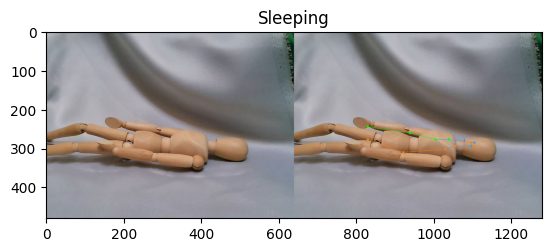

[1.] Sleeping


In [47]:
detect_pose(lmodel)

そもそもPoseが検出できない場合は０＝起きていると判断してしまうので、その対策も必要そう。


# まとめ

精度はまだまだではあるが、MMPoseの出力から体勢を推測する流れのベースラインができました。